# Projet MI201 de Maxime Kunsch et Joseph Mouscadet

## Préliminaires

Avant de commencer le projet, il faut installer les dépendances :

In [ ]:
!pip install torchvision matplotlib requests pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

On télécharge le dataset qui nous est donné.

In [2]:
# Bibliothèques nécessaires
import os
import requests
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models.segmentation import fcn_resnet50

# On utilise CUDA (environnement Google Colab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation: {device}")

# Lien donné du dataset
MODEL_URL = "https://httpmail.onera.fr/21/050a4e5c4611d260c1b8035b5dc8617eO1A12h/coco_sample.pth"
DOWNLOAD_PATH = "./custom_data.pth"

# On crée des dossiers en local s'ils n'existent pas déjà
os.makedirs(os.path.dirname(DOWNLOAD_PATH), exist_ok=True)

# On télécharge le fichier
if not os.path.exists(DOWNLOAD_PATH):
    print("Téléchargement fichier .pth...")
    response = requests.get(MODEL_URL)
    with open(DOWNLOAD_PATH, 'wb') as f:
        f.write(response.content)
    print(f"Téléchargé vers {DOWNLOAD_PATH}")
else:
    print(f"Le dataset a déjà été téléchargé en {DOWNLOAD_PATH}")

# chargement des données
loaded_data = torch.load("custom_data.pth", map_location=device)
print(f"Forme: {loaded_data.shape}")

Utilisation: cuda
Le dataset a déjà été téléchargé en ./custom_data.pth
Forme: torch.Size([9, 3, 520, 520])


<ipython-input-2-16a4769f768f>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load("custom_data.pth", map_location=device)


On charge un modèle et on évalue ses performances sur un échantillon

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 86.9MB/s]


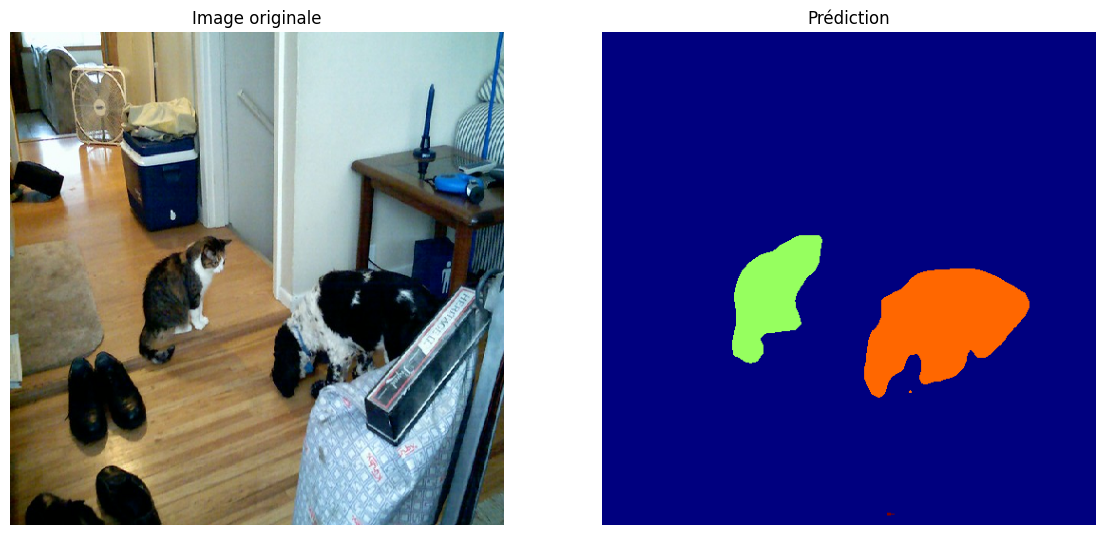

Inférence sur cuda:0
Prediction shape: (520, 520)


In [3]:
# on charge un modèle préentrainé
model = fcn_resnet50(pretrained=True).to(device).eval()

# Preprocess
preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# On prend un sample
sample_idx = 0
input_tensor = preprocess(loaded_data[sample_idx]).unsqueeze(0).to(device)

# inférence
with torch.no_grad():
    output = model(input_tensor)['out'][0]
pred_mask = output.argmax(0).cpu().numpy()

# on prépare l'image pour la prévisu
original_image = loaded_data[sample_idx].cpu().numpy().transpose(1, 2, 0)

# visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# image originale
axes[0].imshow(original_image)
axes[0].set_title('Image originale')
axes[0].axis('off')

# Masque prédit
axes[1].imshow(pred_mask, cmap='jet')
axes[1].set_title('Prédiction')
axes[1].axis('off')

plt.show()

print(f"Inférence sur {input_tensor.device}")
print(f"Prediction shape: {pred_mask.shape}")

Le modèle fonctionne correctement.

## Question 1 : Faire une attaque *untargeted*

In [4]:
sample_idx = 0
original_image = loaded_data[sample_idx].clone().detach()

# Paramètres de l'attaque
epsilon = 0.03  # Perturbation maximale
alpha = 0.01    # step size pour PGD
iterations = 10 # nombre d'iterations pour PGD

Attaque FGSM (Fast Gradient Sign Method) : \
Attaque en une seule étape utilisant la direction du signe du gradient pour perturber les prédictions du modèle.

In [5]:
def fgsm_attack(image, model, epsilon):
    image = image.clone().detach().requires_grad_(True).to(device)

    # Premiere passe
    inputs = preprocess(image).unsqueeze(0)
    outputs = model(inputs)['out']

    # On calcule le loss
    loss = nn.CrossEntropyLoss()(outputs, outputs.argmax(dim=1).detach())

    # Seconde passe en arriere
    loss.backward()

    # on cree l'exemple adversarial
    with torch.no_grad():
        perturbed_image = image + epsilon * image.grad.data.sign()
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image.detach()

Attaque PGD (Projected Gradient Descent) : \
Attaque en plusieurs itérations utilisant également le gradient.

In [6]:
def pgd_attack(image, model, epsilon, alpha, iterations):
    orig_image = image.clone().detach()
    perturbed_image = image.clone().detach()

    for _ in range(iterations):
        perturbed_image = perturbed_image.clone().detach().requires_grad_(True)

        # Premiere passe en avant
        inputs = preprocess(perturbed_image).unsqueeze(0)
        outputs = model(inputs)['out']

        # On calcule le loss
        loss = nn.CrossEntropyLoss()(outputs, outputs.argmax(dim=1).detach())

        # Seconde passe en arriere
        loss.backward()

        # on cree l'exemple adversarial
        with torch.no_grad():
            gradients = perturbed_image.grad.data
            perturbed_image = perturbed_image + alpha * gradients.sign()
            perturbed_image = torch.max(torch.min(perturbed_image,
                                       orig_image + epsilon), orig_image - epsilon)
            perturbed_image = torch.clamp(perturbed_image, 0, 1)

        perturbed_image.grad = None  # On remet les gradients à 0

    return perturbed_image.detach()

Prédictions de l'image originelle:

FGSM Résultats de attaque:


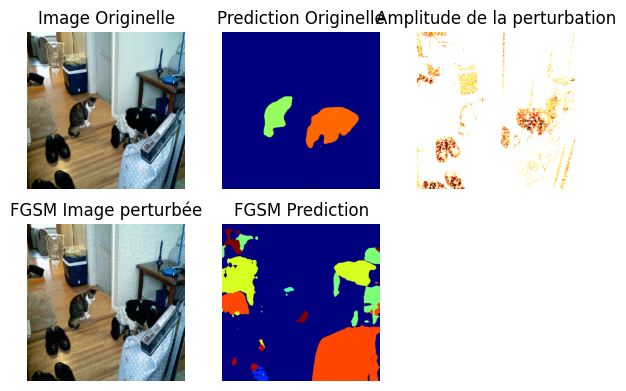


PGD Résultats de attaque:


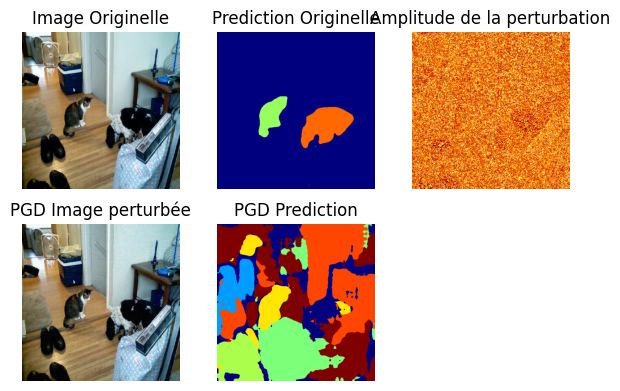

In [8]:
# Génération des exemples
adv_fgsm = fgsm_attack(original_image.clone(), model, epsilon)
adv_pgd = pgd_attack(original_image.clone(), model, epsilon, alpha, iterations)

# Fonction de visualisation
def visualize_results(original, adv, pred_original, pred_adv, title):
    fig, axes = plt.subplots(2, 3, figsize=(6, 4))

    # Image originale et prediction
    axes[0,0].imshow(original.cpu().numpy().transpose(1,2,0))
    axes[0,0].set_title('Image Originelle')
    axes[0,0].axis('off')

    axes[0,1].imshow(pred_original, cmap='jet')
    axes[0,1].set_title('Prediction Originelle')
    axes[0,1].axis('off')

    # Image attaquée et prediction
    axes[1,0].imshow(adv.cpu().numpy().transpose(1,2,0))
    axes[1,0].set_title(f'{title} Image perturbée')
    axes[1,0].axis('off')

    axes[1,1].imshow(pred_adv, cmap='jet')
    axes[1,1].set_title(f'{title} Prediction')
    axes[1,1].axis('off')

    # Difference
    diff = (adv - original).abs().sum(dim=0).cpu().numpy()
    axes[0,2].imshow(diff, cmap='hot')
    axes[0,2].set_title('Amplitude de la perturbation')
    axes[0,2].axis('off')

    axes[1,2].axis('off')
    plt.tight_layout()
    plt.show()

# Récupérer les predictions
def get_prediction(image):
    with torch.no_grad():
        inputs = preprocess(image).unsqueeze(0).to(device)
        outputs = model(inputs)['out'][0]
    return outputs.argmax(0).cpu().numpy()

# Generer et visualiser les résultats
print("Prédictions de l'image originelle:")
original_pred = get_prediction(original_image)

print("\nFGSM Résultats de attaque:")
adv_fgsm_pred = get_prediction(adv_fgsm)
visualize_results(original_image, adv_fgsm, original_pred, adv_fgsm_pred, "FGSM")

print("\nPGD Résultats de attaque:")
adv_pgd_pred = get_prediction(adv_pgd)
visualize_results(original_image, adv_pgd, original_pred, adv_pgd_pred, "PGD")

On voit que les deux attaques fonctionnent correctement. L'attaque PGD fonctionne mieux que l'attaque FGSM, mais cela est logique car la perturbation PGD a une norme plus élevée.

## Question 2 : Faire une attaque *targeted*

Classes MS-COCO : \
0: background, 1: avion, 2: vélo, 3: oiseau, 4: bateau,
5: bouteille, 6: bus, 7: voiture, 8: chat, 9: chaise,
10: vache, 11: table à manger, 12: chien, 13: cheval,
14: moto, 15: personne, 16: plante en pot,
17: chèvre, 18: canapé, 19: train, 20: télévision

In [9]:
sample_idx = 0
original_image = loaded_data[sample_idx].clone().detach()

# Definition des paramètres cibles
target_class = 1   # COCO classe 'avion'
epsilon = 0.01    # Perturbation max
alpha = 0.005      # Step size
iterations = 80    # Attacque iterations

# Récupérer les dimensions de l'image (marche pour les formats [C,H,W] et [B,C,H,W])
if len(original_image.shape) == 3:
    # Image simple [channels, hauuteur, largeur]
    c, h, w = original_image.shape
else:
    # Batch format [batch, channels, hauteur, largeur]
    b, c, h, w = original_image.shape

# Créer masque cible (même dimension spatiale que la sortie)
target_mask = torch.full((h, w), target_class, dtype=torch.long, device=device)

In [10]:
def targeted_pgd_attack(image, model, target_mask, epsilon, alpha, iterations):
    orig_image = image.clone().detach()

    # Gérer les cas d'images seules (ajouter batch dimension)
    if len(orig_image.shape) == 3:
        orig_image = orig_image.unsqueeze(0)

    perturbed_image = orig_image.clone().detach()

    for _ in range(iterations):
        perturbed_image = perturbed_image.clone().detach().requires_grad_(True)

        # Forward pass
        inputs = preprocess(perturbed_image)
        outputs = model(inputs)['out']

        # Calculer la loss par rapport à la cible
        loss = nn.CrossEntropyLoss()(outputs, target_mask.unsqueeze(0))

        # Backward pass
        loss.backward()

        # Créer un exemple
        with torch.no_grad():
            gradients = perturbed_image.grad.data
            perturbed_image = perturbed_image - alpha * gradients.sign()
            perturbed_image = torch.max(torch.min(perturbed_image,
                                       orig_image + epsilon), orig_image - epsilon)
            perturbed_image = torch.clamp(perturbed_image, 0, 1)

        perturbed_image.grad = None

    # Retirer batch dimension si on l'avait ajouté
    if len(image.shape) == 3:
        return perturbed_image.squeeze(0).detach()
    return perturbed_image.detach()

In [11]:
adv_targeted = targeted_pgd_attack(original_image.clone(), model, target_mask, epsilon, alpha, iterations)

Résultats de lattaque ciblée:


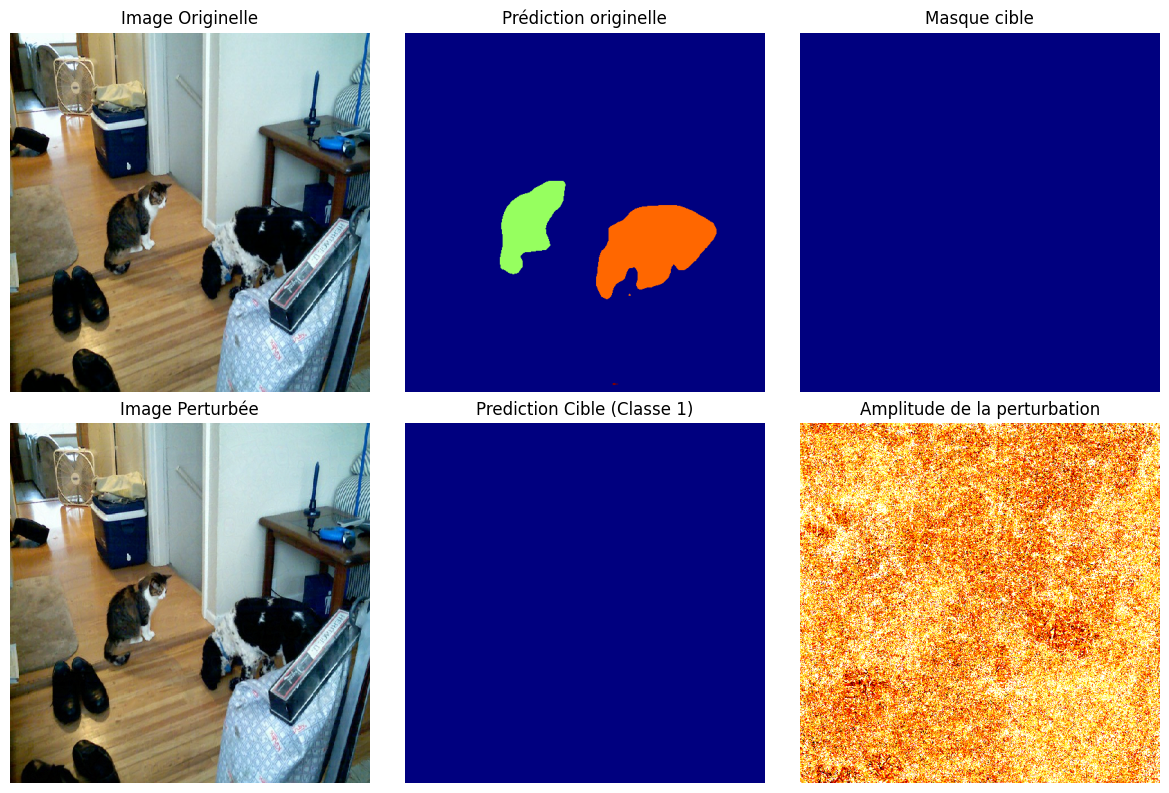

In [13]:
def get_prediction(image):
    with torch.no_grad():
        inputs = preprocess(image).unsqueeze(0).to(device)
        outputs = model(inputs)['out'][0]
    return outputs.argmax(0).cpu().numpy()

def visualize_targeted(original, adv, target_mask):
    orig_pred = get_prediction(original)
    adv_pred = get_prediction(adv)

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Image originale et prediction
    axes[0,0].imshow(original.cpu().numpy().transpose(1,2,0))
    axes[0,0].set_title('Image Originelle')
    axes[0,0].axis('off')

    axes[0,1].imshow(orig_pred, cmap='jet')
    axes[0,1].set_title('Prédiction originelle')
    axes[0,1].axis('off')

    # Image attaquée et prediction
    axes[1,0].imshow(adv.cpu().numpy().transpose(1,2,0))
    axes[1,0].set_title('Image Perturbée')
    axes[1,0].axis('off')

    axes[1,1].imshow(adv_pred, cmap='jet')
    axes[1,1].set_title(f'Prediction Cible (Classe {target_class})')
    axes[1,1].axis('off')

    # Masque cible and difference
    axes[0,2].imshow(target_mask.cpu().numpy(), cmap='jet')
    axes[0,2].set_title('Masque cible')
    axes[0,2].axis('off')

    diff = (adv - original).abs().sum(dim=0).cpu().numpy()
    axes[1,2].imshow(diff, cmap='hot')
    axes[1,2].set_title('Amplitude de la perturbation')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()

# Faire la visualization
print("Résultats de lattaque ciblée:")
visualize_targeted(original_image, adv_targeted, target_mask)

In [ ]:
print(get_prediction(adv_targeted))

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


On voit que la prédiction est correctement affectée. Le modèle prédit bien notre cible à savoir un avion (la classe 1).

## Question 3 : Évolution de la performance vis à vis de la norme autorisée de l'attaque

In [14]:
import numpy as np

In [15]:
# Créer un masque cible pour les images redimensionnées
h, w = original_image.shape[-2:]
target_class = 15  # Person class
target_mask = torch.full((h, w), target_class, dtype=torch.long, device=device)

# Paramètres de l'attaque
alpha = 0.005
iterations = 20  # Reduction des itérations pour la vitesse

Processing ε=0.0005
Epsilon: 0.001 | Réussite: 0.86%
Processing ε=0.0010
Epsilon: 0.001 | Réussite: 5.26%
Processing ε=0.0015
Epsilon: 0.002 | Réussite: 9.50%
Processing ε=0.0020
Epsilon: 0.002 | Réussite: 13.62%
Processing ε=0.0025
Epsilon: 0.003 | Réussite: 16.65%
Processing ε=0.0030
Epsilon: 0.003 | Réussite: 16.73%
Processing ε=0.0035
Epsilon: 0.004 | Réussite: 48.13%
Processing ε=0.0040
Epsilon: 0.004 | Réussite: 54.64%
Processing ε=0.0045
Epsilon: 0.005 | Réussite: 47.95%
Processing ε=0.0050
Epsilon: 0.005 | Réussite: 75.28%
Processing ε=0.0055
Epsilon: 0.005 | Réussite: 89.58%
Processing ε=0.0060
Epsilon: 0.006 | Réussite: 95.86%
Processing ε=0.0065
Epsilon: 0.007 | Réussite: 99.22%
Processing ε=0.0070
Epsilon: 0.007 | Réussite: 99.90%
Processing ε=0.0075
Epsilon: 0.007 | Réussite: 99.56%
Processing ε=0.0080
Epsilon: 0.008 | Réussite: 99.72%
Processing ε=0.0085
Epsilon: 0.009 | Réussite: 100.00%
Processing ε=0.0090
Epsilon: 0.009 | Réussite: 100.00%
Processing ε=0.0095
Epsilon: 

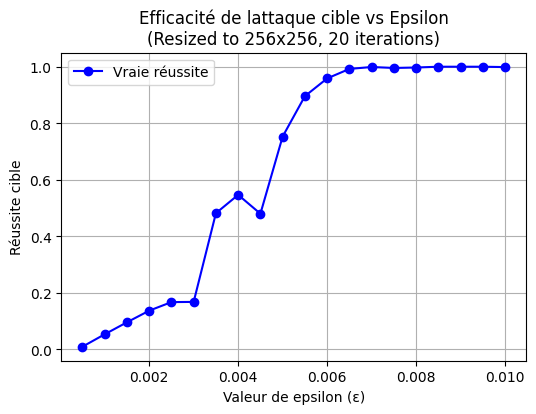

In [16]:
epsilons = np.linspace(0.0005, 0.01, 20)  # 8 valeurs epsilon de 0.01 à 0.1

# Calculer les taux de réussites
success_rates = []
for eps in epsilons:
    print(f"Processing ε={eps:.4f}")
    adv = targeted_pgd_attack(original_image, model, target_mask, eps, alpha, iterations)

    with torch.no_grad():
        outputs = model(preprocess(adv).unsqueeze(0))['out']
        pred_mask = outputs.argmax(1).squeeze().cpu().numpy()

    success_rate = (pred_mask == target_mask.cpu().numpy()).mean()
    success_rates.append(success_rate)
    print(f"Epsilon: {eps:.3f} | Réussite: {success_rate:.2%}")


# Plot results
plt.figure(figsize=(6, 4))
plt.plot(epsilons, success_rates, 'bo-', label='Vraie réussite')
plt.xlabel('Valeur de epsilon (ε)')
plt.ylabel('Réussite cible')
plt.title('Efficacité de lattaque cible vs Epsilon\n(Resized to 256x256, 20 iterations)')
plt.legend()
plt.grid(True)
plt.show()

On voit que si epsilon augmente alors la réussite aussi. Ce qui parait logique.

1.   Élément de liste
2.   Élément de liste



## Question 4 : Comment se comporte l'attaque sur un autre réseau ?

On prend cette attaque entraînée sur FCN-ResNet50 et on voit comment elle se comporte sur un autre réseau : DeepLabV3-ResNet50 (même backbone).

In [17]:
from torchvision.models.segmentation import deeplabv3_resnet50

# On charge les deux modèles
source_model = fcn_resnet50(pretrained=True).to(device).eval()
target_model = deeplabv3_resnet50(pretrained=True).to(device).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 89.4MB/s]


In [18]:
# Paramètres (utiliser les même que ceeux de l'attaque précédente)
epsilon = 0.01  # Utiliser le meilleur epsilon
alpha = 0.005
iterations = 20
target_class = 1  # Classe avion

# Charger les données
loaded_data = torch.load("custom_data.pth", map_location=device)
original_image = loaded_data[0].clone().detach()  # Utiliser la première image
h, w = original_image.shape[-2:]
target_mask = torch.full((h, w), target_class, dtype=torch.long, device=device)

# Générer des exemples
adv_example = targeted_pgd_attack(original_image, source_model, target_mask, epsilon, alpha, iterations)

<ipython-input-18-34c2bd793ca9>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load("custom_data.pth", map_location=device)


In [19]:
def evaluate_transfer(source_model, target_model, original, adversarial, target_mask):
    """Evaluer la réussite de lattaque sur les modèles"""
    results = {}

    for name, model in [('Source', source_model), ('Target', target_model)]:
        # Récupérer la prédiction originelle
        with torch.no_grad():
            clean_out = model(preprocess(original.unsqueeze(0)))['out'].squeeze()
            clean_acc = (clean_out.argmax(0) == target_mask).float().mean().item()

            # Récupérer la prédiction attaquée
            adv_out = model(preprocess(adversarial.unsqueeze(0)))['out'].squeeze()
            adv_acc = (adv_out.argmax(0) == target_mask).float().mean().item()

        results[name] = {
            'clean_acc': clean_acc,
            'att_acc': adv_acc,
            'réussite': adv_acc - clean_acc
        }

    return results

In [20]:
# Evaluer la transférabilité
results = evaluate_transfer(source_model, target_model, original_image, adv_example, target_mask)

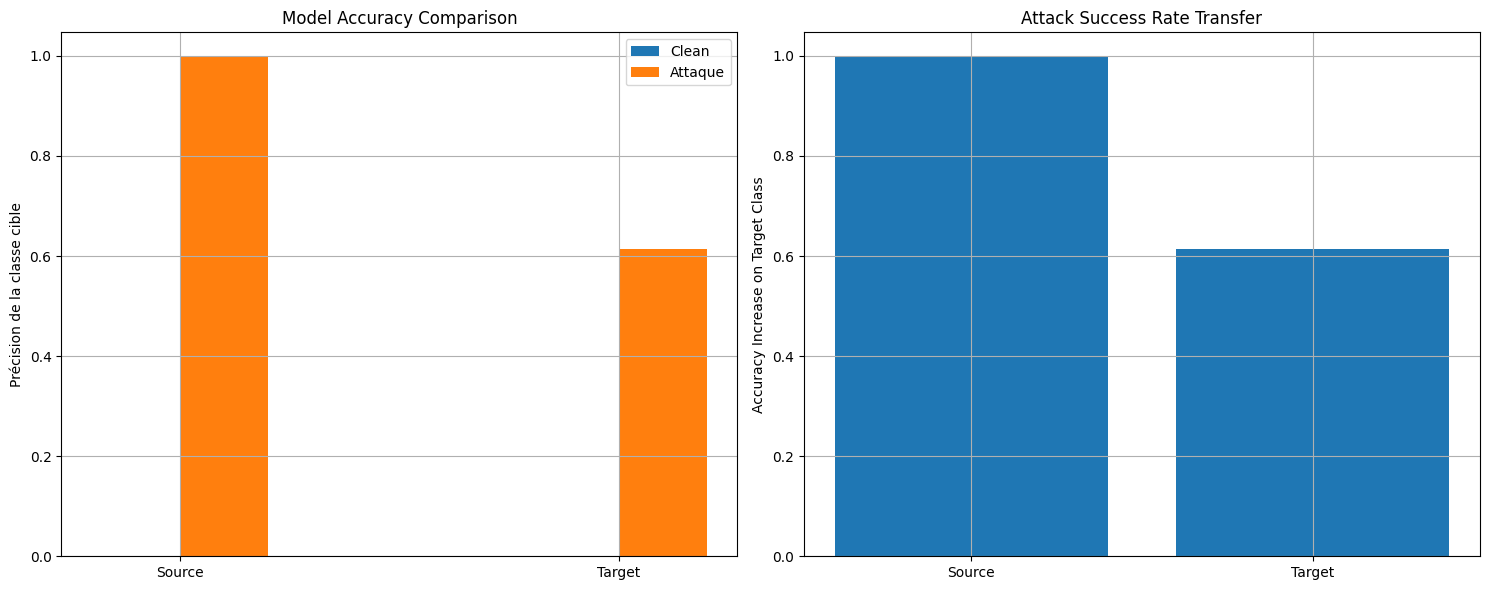

Résultats de la transferabilité de l'attaque (ε=0.01):
Source Modèle:
  Clean Accuracy: 0.00%
  Précision de l'attaque 99.73%
  Réussite: 99.73%

Target Modèle:
  Clean Accuracy: 0.00%
  Précision de l'attaque 61.41%
  Réussite: 61.41%



In [22]:
# Visualisation
def plot_transfer_results(results):
    models = list(results.keys())
    clean_accs = [results[m]['clean_acc'] for m in models]
    adv_accs = [results[m]['att_acc'] for m in models]
    success_rates = [results[m]['réussite'] for m in models]

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Comparaison de la précision
    ax[0].bar(np.arange(len(models))-0.1, clean_accs, 0.2, label='Clean')
    ax[0].bar(np.arange(len(models))+0.1, adv_accs, 0.2, label='Attaque')
    ax[0].set_title('Model Accuracy Comparison')
    ax[0].set_xticks(range(len(models)))
    ax[0].set_xticklabels(models)
    ax[0].set_ylabel('Précision de la classe cible')
    ax[0].legend()
    ax[0].grid(True)

    # Comparaison de la réussite
    ax[1].bar(models, success_rates)
    ax[1].set_title('Attack Success Rate Transfer')
    ax[1].set_ylabel('Accuracy Increase on Target Class')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_transfer_results(results)

# Afficher les résultats
print(f"Résultats de la transferabilité de l'attaque (ε={epsilon}):")
for model, metrics in results.items():
    print(f"{model} Modèle:")
    print(f"  Clean Accuracy: {metrics['clean_acc']:.2%}")
    print(f"  Précision de l'attaque {metrics['att_acc']:.2%}")
    print(f"  Réussite: {metrics['réussite']:.2%}\n")

On voit que ce n'est pas très efficace.

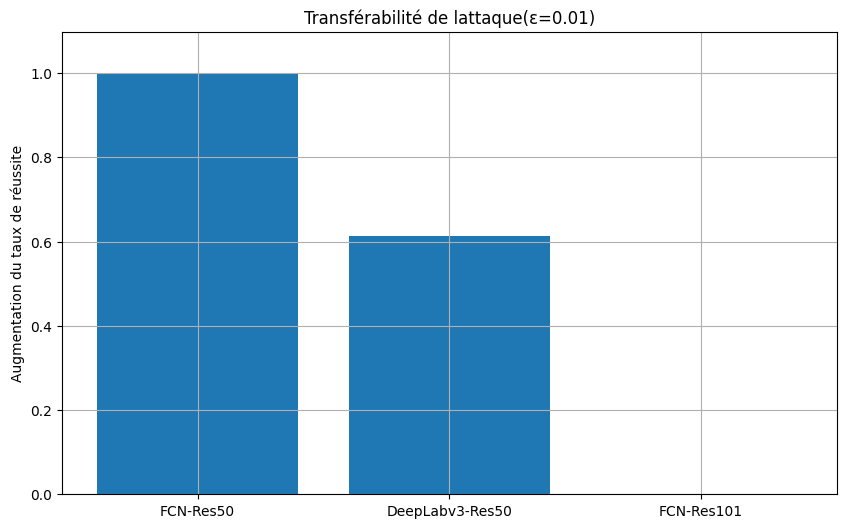

In [25]:
from torchvision.models.segmentation import fcn_resnet101

# Tester sur différentes architectures
models = {
    'FCN-Res50': fcn_resnet50(pretrained=True).eval().to(device),
    'DeepLabv3-Res50': deeplabv3_resnet50(pretrained=True).eval().to(device),
    'FCN-Res101': fcn_resnet101(pretrained=True).eval().to(device)
}

transfer_results = {}
for model_name, model in models.items():
    res = evaluate_transfer(source_model, model, original_image, adv_example, target_mask)
    transfer_results[model_name] = res['Target']['réussite']

# Transférabilité
plt.figure(figsize=(10, 6))
plt.bar(transfer_results.keys(), transfer_results.values())
plt.title(f'Transférabilité de lattaque(ε={epsilon})')
plt.ylabel('Augmentation du taux de réussite')
plt.ylim(0, max(transfer_results.values())*1.1)
plt.grid(True)
plt.show()

## Question 5 : Comment se comporte l'attaque sur un autre réseau, si on l'a entraînée sur un ensemble de réseau ?

In [26]:
from torchvision.models.segmentation import (
    fcn_resnet50, fcn_resnet101, deeplabv3_resnet50, deeplabv3_resnet101
)
from torchvision.transforms import Normalize

In [27]:
resize_size = (256, 256)  # Plus rapide
target_class = 15  # Classe personne
epsilon = 0.03
alpha = 0.005
iterations = 30

In [28]:
original_image = loaded_data[0].clone().detach().requires_grad_(False)
original_image = torch.nn.functional.interpolate(original_image.unsqueeze(0), size=resize_size, mode='bilinear')[0]

In [29]:
# Créer un masque cible
h, w = original_image.shape[-2:]
target_mask = torch.full((h, w), target_class, dtype=torch.long, device=device)

# Normalisation
preprocess = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Charger les modèles
ensemble_models = {
    'FCN50': fcn_resnet50(pretrained=True).eval().to(device),
    'FCN101': fcn_resnet101(pretrained=True).eval().to(device),
    'DeepLab50': deeplabv3_resnet50(pretrained=True).eval().to(device)
}

# Charger les évaluations
eval_model = deeplabv3_resnet101(pretrained=True).eval().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 147MB/s]


In [30]:
def ensemble_targeted_attack(image, models, target_mask, epsilon, alpha, iterations):
    orig_image = image.clone().detach()
    perturbed_image = image.clone().detach()

    for _ in range(iterations):
        perturbed_image = perturbed_image.clone().detach().requires_grad_(True)

        total_grad = torch.zeros_like(perturbed_image)

        for model in models.values():
            outputs = model(preprocess(perturbed_image.unsqueeze(0)))['out']
            loss = nn.CrossEntropyLoss()(outputs, target_mask.unsqueeze(0))
            loss.backward()

            if perturbed_image.grad is not None:
                total_grad += perturbed_image.grad.data
            model.zero_grad()
            torch.cuda.empty_cache()

        # Mettre à jour
        with torch.no_grad():
            avg_grad = total_grad / len(models)
            perturbed_image = perturbed_image - alpha * avg_grad.sign()
            perturbed_image = torch.max(torch.min(perturbed_image, orig_image + epsilon), orig_image - epsilon)
            perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image.detach()

In [31]:
# Génerer l'attaque
print("Généraion de l'attaque...")
adv_example = ensemble_targeted_attack(
    original_image, ensemble_models, target_mask, epsilon, alpha, iterations
)

Généraion de l'attaque...


In [32]:
# Fonction d'évaluation
def evaluate_attack(image, adv, models, target_mask):
    results = {}

    for name, model in models.items():
        with torch.no_grad():
            # Précision de base
            clean_out = model(preprocess(image.unsqueeze(0)))['out']
            clean_acc = (clean_out.argmax(1) == target_mask).float().mean().item()

            # Précision de l'attaque
            adv_out = model(preprocess(adv.unsqueeze(0)))['out']
            adv_acc = (adv_out.argmax(1) == target_mask).float().mean().item()

        results[name] = {
            'clean': clean_acc,
            'att': adv_acc,
            'delta': adv_acc - clean_acc
        }

    return results


Evaluation des résultats...

Model Ensemble Resultats:
FCN50:
  Clean: 0.00% → Attaque: 100.00%
  Δ: +100.00%

FCN101:
  Clean: 0.00% → Attaque: 100.00%
  Δ: +100.00%

DeepLab50:
  Clean: 0.00% → Attaque: 100.00%
  Δ: +100.00%


Unseen Model Results:
DeepLab101:
  Clean: 0.00% → Attaque: 100.00%
  Δ: +100.00%



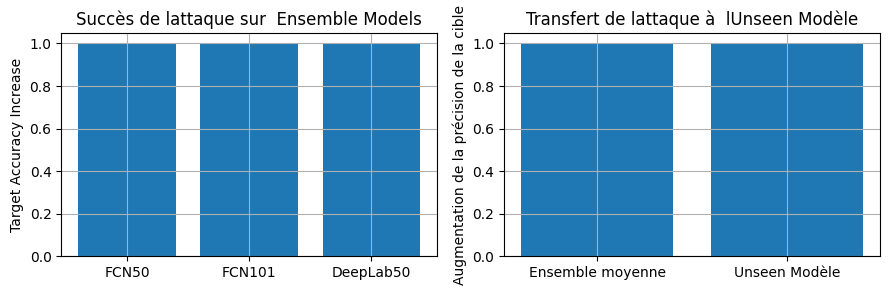

In [33]:
# Evaluation
print("\nEvaluation des résultats...")
ensemble_results = evaluate_attack(original_image, adv_example, ensemble_models, target_mask)
eval_results = evaluate_attack(original_image, adv_example, {'DeepLab101': eval_model}, target_mask)

# Visualisation
def plot_results(ensemble_res, eval_res):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

    # Résultats d'ensemble
    models = list(ensemble_res.keys())
    deltas = [ensemble_res[m]['delta'] for m in models]
    ax1.bar(models, deltas)
    ax1.set_title('Succès de lattaque sur  Ensemble Models')
    ax1.set_ylabel('Target Accuracy Increase')
    ax1.grid(True)

    # Résultats de transfert
    ax2.bar(['Ensemble moyenne', 'Unseen Modèle'],
            [np.mean(deltas), eval_res['DeepLab101']['delta']])
    ax2.set_title('Transfert de lattaque à  lUnseen Modèle')
    ax2.set_ylabel('Augmentation de la précision de la cible')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Resultats
print("\nModèle Ensemble Resultats:")
for model, res in ensemble_results.items():
    print(f"{model}:")
    print(f"  Clean: {res['clean']:.2%} → Attaque: {res['att']:.2%}")
    print(f"  Δ: {res['delta']:+.2%}\n")

print("\nUnseen Modèle Resultats:")
for model, res in eval_results.items():
    print(f"{model}:")
    print(f"  Clean: {res['clean']:.2%} → Attaque: {res['att']:.2%}")
    print(f"  Δ: {res['delta']:+.2%}\n")

plot_results(ensemble_results, eval_results)

C'est plus efficace mais très sensible à la valeur d'epsilon.